In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.svm import SVC

from sklearn.inspection import permutation_importance
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier

In [8]:
# load testing and training

# Load the CSV files
binary_testing_htr = pd.read_csv("Binary_Testing_HTR.csv")
binary_training_htr = pd.read_csv("Binary_Training_HTR.csv")
binary_testing_no_htr = pd.read_csv("Binary_Testing_No_HTR.csv")
binary_training_no_htr = pd.read_csv("Binary_Training_No_HTR.csv")


def encode_column(df, column):
    if column in df.columns:
        df[column] = df[column].map({"H": 1, "A": 0, "D": 0})
    return df

# encoding t'o F' in all datasetsTR
binary_testing_htr = encode_column(binary_testing_htr, "FTR")
binary_training_htr = encode_column(binary_training_htr, "FTR")
binary_testing_no_htr = encode_column(binary_testing_no_htr, "FTR")
binary_training_no_htr = encode_column(binary_training_no_htr, "FTR")

# encoding 'to HTR
binary_testing_htr = encode_column(binary_testing_htr, "HTR")
binary_training_htr = encode_column(binary_training_htr, "HTR")

In [9]:
# Split into X and y
X_train_htr = binary_training_htr.drop(columns=["FTR"])
y_train_htr = binary_training_htr["FTR"]

X_test_htr = binary_testing_htr.drop(columns=["FTR"])
y_test_htr = binary_testing_htr["FTR"]

X_train_no_htr = binary_training_no_htr.drop(columns=["FTR"])
y_train_no_htr = binary_training_no_htr["FTR"]

X_test_no_htr = binary_testing_no_htr.drop(columns=["FTR"])
y_test_no_htr = binary_testing_no_htr["FTR"]

In [10]:
scaler = MinMaxScaler()
X_train_htr = scaler.fit_transform(X_train_htr)
X_test_htr = scaler.transform(X_test_htr)
X_train_no_htr = scaler.fit_transform(X_train_no_htr)
X_test_no_htr = scaler.transform(X_test_no_htr)

In [11]:
def print_cm(y_value, this_y_pred, method, Encoder=None, class_report=False):
    # Print classification report if requested
    if class_report:
        print(classification_report(y_value, this_y_pred))

    # Print performance metrics
    print("Accuracy:", accuracy_score(y_value, this_y_pred))
    print("Precision:", precision_score(y_value, this_y_pred, average=method))
    print("Recall:", recall_score(y_value, this_y_pred, average=method))
    print("F1 Score:", f1_score(y_value, this_y_pred, average=method))

    # Generate confusion matrix
    confusion = confusion_matrix(y_value, this_y_pred)
    sns.heatmap(confusion, annot=True, fmt='d',
                xticklabels=[class_name for class_name in Encoder.classes_] if Encoder else ['0', '1'],
                yticklabels=[class_name for class_name in Encoder.classes_] if Encoder else ['0', '1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [12]:
# Train SVM with linear kernel
svm_model = SVC(kernel="linear")
svm_model.fit(X_train_no_htr, y_train_no_htr)
y_pred_svm = svm_model.predict(X_test_no_htr)
y_pred_train_svm = svm_model.predict(X_train_no_htr)
print("SVM Train Accuracy:", accuracy_score(y_train_no_htr, y_pred_train_svm))
print("SVM Test Accuracy:", accuracy_score(y_test_no_htr, y_pred_svm))

print("SVM Train F1 Score:", f1_score(y_train_no_htr, y_pred_train_svm))
print("SVM Test F1 Score:", f1_score(y_test_no_htr, y_pred_svm))

SVM Train Accuracy: 0.6555921052631579
SVM Test Accuracy: 0.6634615384615384
SVM Train F1 Score: 0.566100290095317
SVM Test F1 Score: 0.5977011494252874


Accuracy: 0.6555921052631579
Precision: 0.6540966330301199
Recall: 0.641031604918606
F1 Score: 0.6402903959339417


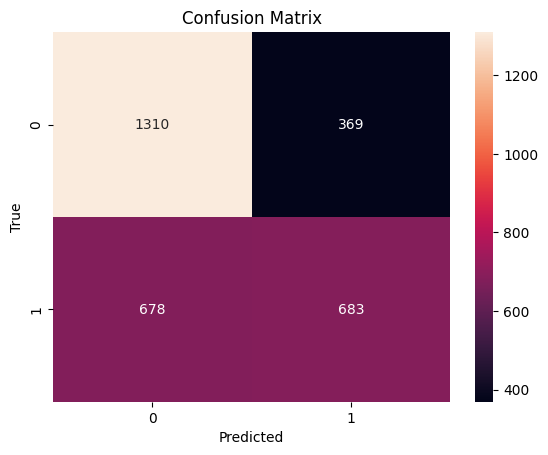

In [13]:
print_cm(y_train_no_htr, svm_model.predict(X_train_no_htr), 'macro')

              precision    recall  f1-score   support

           0       0.69      0.74      0.71       350
           1       0.63      0.57      0.60       274

    accuracy                           0.66       624
   macro avg       0.66      0.65      0.65       624
weighted avg       0.66      0.66      0.66       624

Accuracy: 0.6634615384615384
Precision: 0.6576012354152367
Recall: 0.6532429614181439
F1 Score: 0.65422247553909


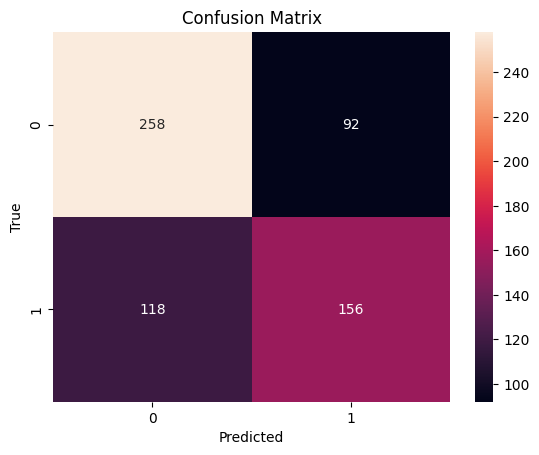

In [14]:
print_cm(y_test_no_htr, y_pred_svm, 'macro', class_report=True)

In [15]:
feature_names_no_htr = binary_testing_no_htr.drop(columns=["FTR"]).columns
feature_names_htr = binary_testing_htr.drop(columns=["FTR"]).columns

SVM Train Accuracy: 0.656578947368421
SVM Test Accuracy: 0.6618589743589743


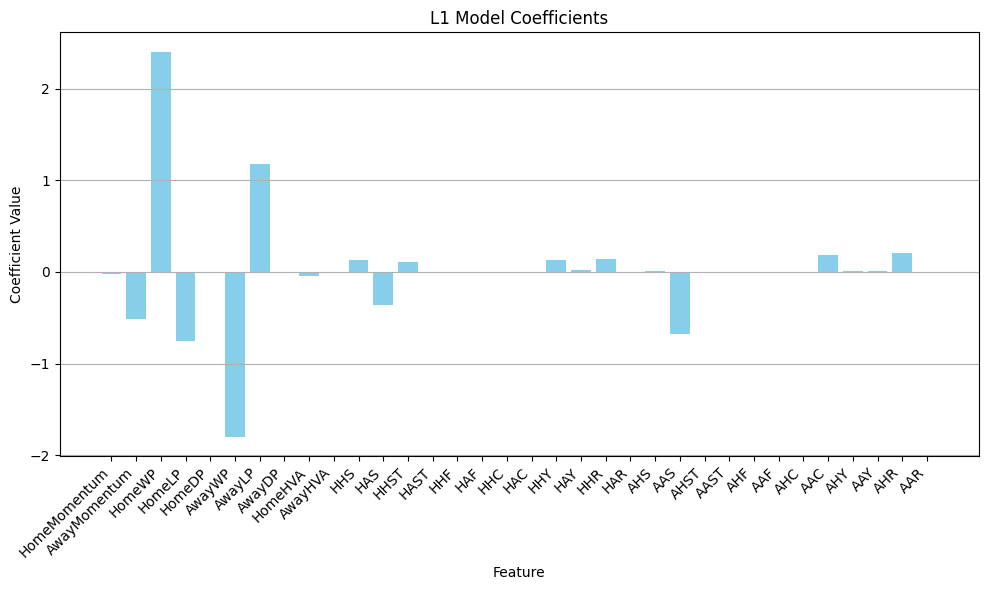

In [16]:
# L1 Regularization (Lasso)
from sklearn.linear_model import LogisticRegression

l1_log_model = LogisticRegression(penalty="l1", solver="liblinear", random_state=0) # SVM wasn't working with l2??
l1_log_model.fit(X_train_no_htr, y_train_no_htr)
y_pred_l1_log = l1_log_model.predict(X_test_no_htr)
print("SVM Train Accuracy:", accuracy_score(y_train_no_htr, l1_log_model.predict(X_train_no_htr)))
print("SVM Test Accuracy:", accuracy_score(y_test_no_htr, y_pred_l1_log))

plt.figure(figsize=(10, 6))
plt.bar(feature_names_no_htr, l1_log_model.coef_[0], color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Coefficient Value')
plt.title('L1 Model Coefficients')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

SVM Train Accuracy: 0.6585526315789474
SVM Test Accuracy: 0.6682692307692307


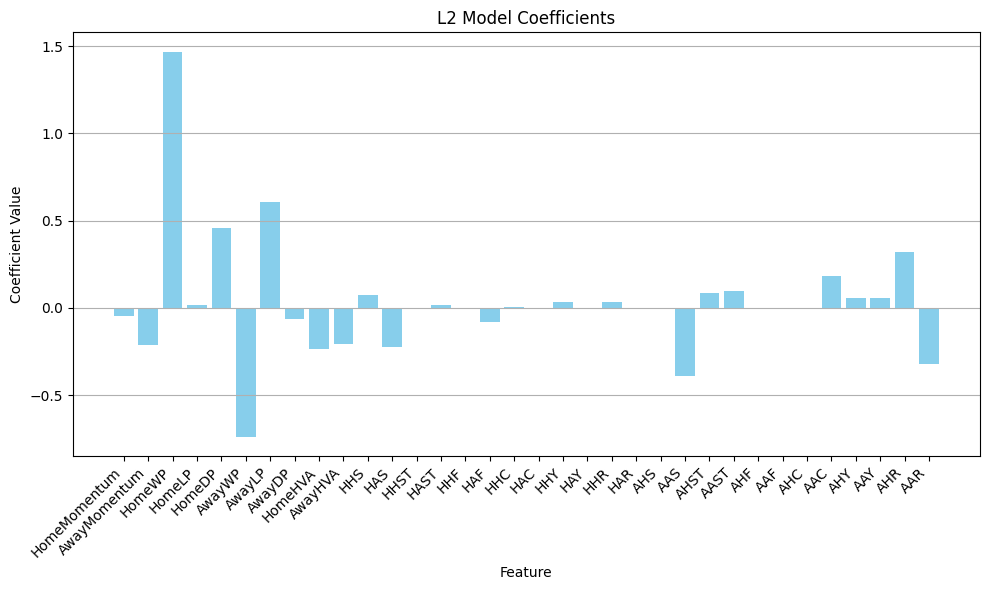

In [17]:
# L1 Regularization using linearSVC so I can use l1
l1_svm_model = LinearSVC(penalty='l1', C=10.0, random_state=0, max_iter=3000) # 100 works better
l1_svm_model.fit(X_train_no_htr, y_train_no_htr)
y_pred_l1_svm = l1_svm_model.predict(X_test_no_htr)
print("SVM Train Accuracy:", accuracy_score(y_train_no_htr, l1_svm_model.predict(X_train_no_htr)))
print("SVM Test Accuracy:", accuracy_score(y_test_no_htr, y_pred_l1_svm))

plt.figure(figsize=(10, 6))
plt.bar(feature_names_no_htr, l1_svm_model.coef_[0], color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Coefficient Value')
plt.title('L2 Model Coefficients')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

SVM Train Accuracy: 0.656578947368421
SVM Test Accuracy: 0.6650641025641025


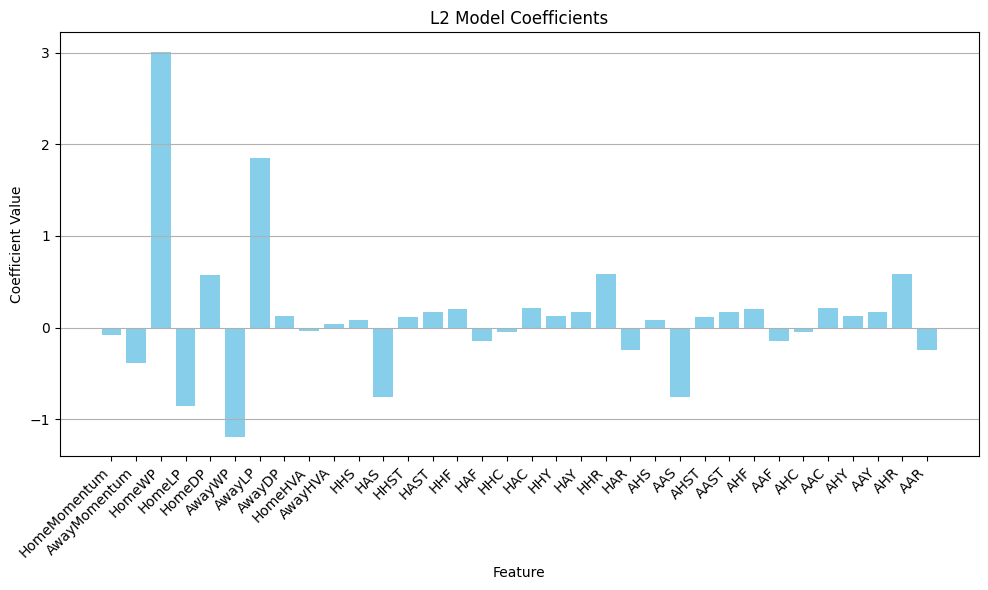

In [18]:
# L2 Regularization (Ridge)
l2_svm_model = SVC(kernel='linear', C=10.0, random_state=0)
l2_svm_model.fit(X_train_no_htr, y_train_no_htr)
y_pred_l2_svm = l2_svm_model.predict(X_test_no_htr)
print("SVM Train Accuracy:", accuracy_score(y_train_no_htr, l2_svm_model.predict(X_train_no_htr)))
print("SVM Test Accuracy:", accuracy_score(y_test_no_htr, y_pred_l2_svm))

plt.figure(figsize=(10, 6))
plt.bar(feature_names_no_htr, l2_svm_model.coef_[0], color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Coefficient Value')
plt.title('L2 Model Coefficients')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

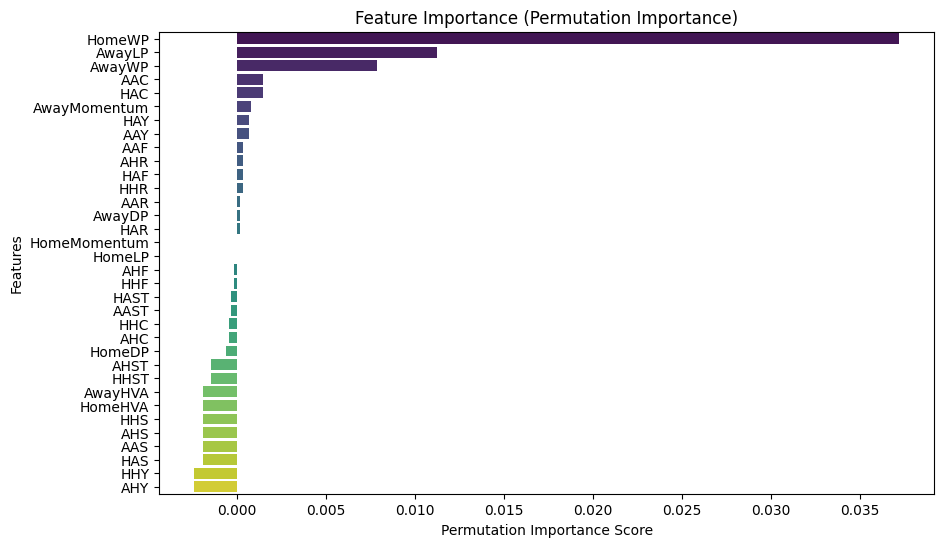

In [19]:
X_test_df = pd.DataFrame(X_test_no_htr, columns=feature_names_no_htr)
perm_importance = permutation_importance(svm_model, X_test_no_htr, y_test_no_htr, scoring="accuracy", n_repeats=10, random_state=42)
perm_importance = np.array(perm_importance.importances_mean)
sorted_idx = np.argsort(perm_importance)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=perm_importance[sorted_idx], y=feature_names_no_htr[sorted_idx], palette="viridis", hue=feature_names_no_htr[sorted_idx], legend=False)
plt.xlabel("Permutation Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance (Permutation Importance)")
plt.show()

Order is off I have to decide what to do first
Im thinking
1. variance threshold or feature elim
2. feature extraction
3. l1/l2
4. compare difference between HTR and no_HTR

#Variance Threshold NO HTR

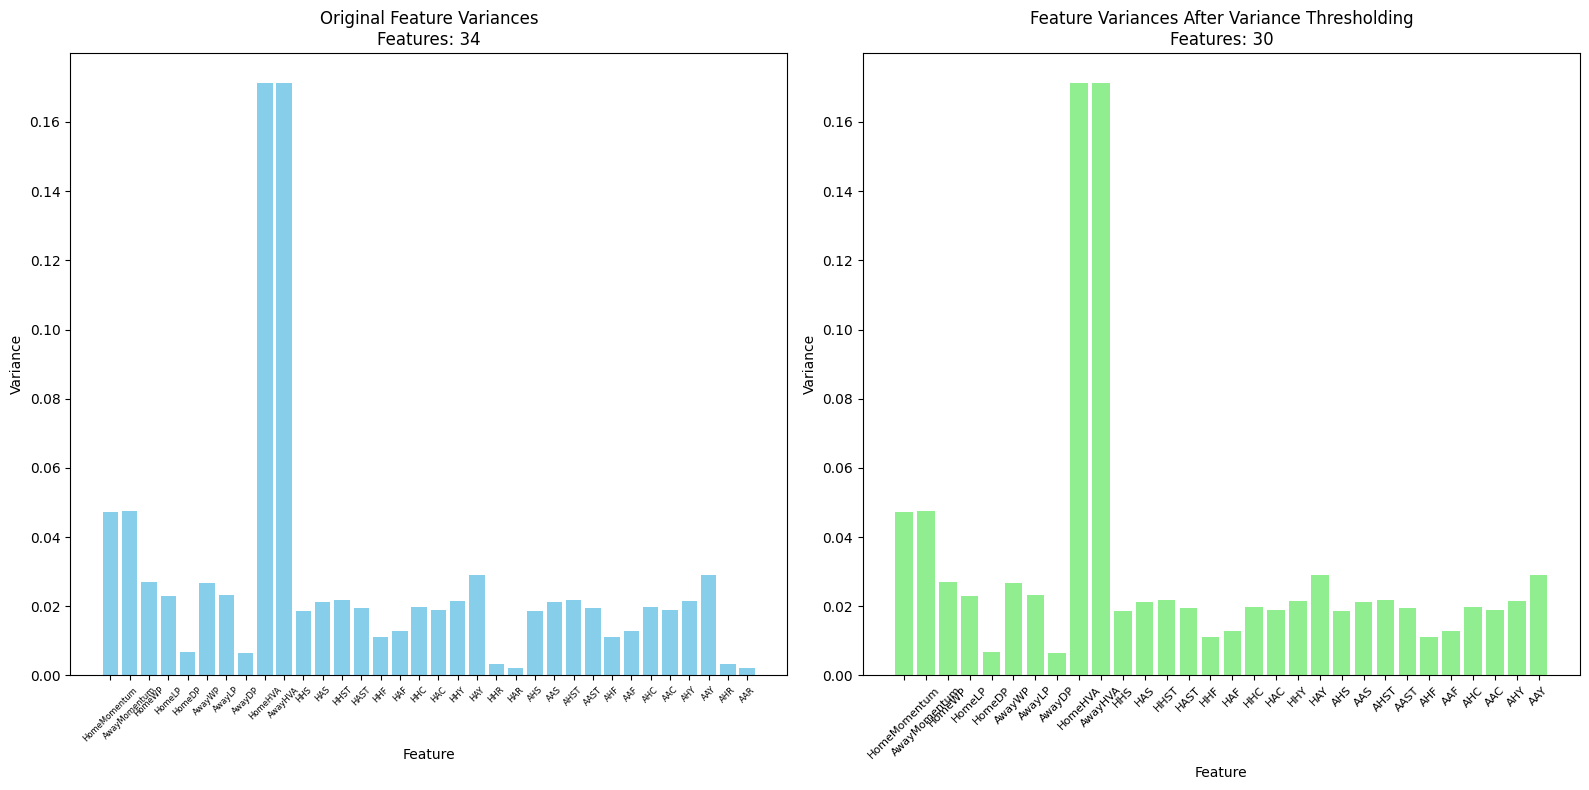

Number of features before variance threshold: 34
Number of features after variance threshold: 30


In [20]:
# variance threshold ofr NO_HTR
threshold = 0.005
selector_no_htr = VarianceThreshold(threshold)

X_train_no_htr_selected = selector_no_htr.fit_transform(X_train_no_htr)
X_test_no_htr_selected = selector_no_htr.transform(X_test_no_htr)

# original features
variances_train_no_htr_original = np.var(X_train_no_htr, axis=0)
# selected features
variances_train_no_htr_selected = np.var(X_train_no_htr_selected, axis=0)

# feature_names_no_htr comes from above jupyter cells
num_features_before = X_train_no_htr.shape[1]
num_features_after = X_train_no_htr_selected.shape[1]

plt.figure(figsize=(16, 8))

# original
plt.subplot(1, 2, 1)
plt.bar(feature_names_no_htr, variances_train_no_htr_original, color='skyblue')
plt.title(f'Original Feature Variances\nFeatures: {num_features_before}')
plt.xlabel('Feature')
plt.ylabel('Variance')
plt.xticks(rotation=45 , fontsize=6)

# selected
plt.subplot(1, 2, 2)
plt.bar(feature_names_no_htr[selector_no_htr.get_support()], variances_train_no_htr_selected, color='lightgreen')
plt.title(f'Feature Variances After Variance Thresholding\nFeatures: {num_features_after}')
plt.xlabel('Feature')
plt.ylabel('Variance')
plt.xticks(rotation=45, fontsize=8)

plt.tight_layout()
plt.show()

print(f"Number of features before variance threshold: {num_features_before}")
print(f"Number of features after variance threshold: {num_features_after}")


#Variance Threshold HTR

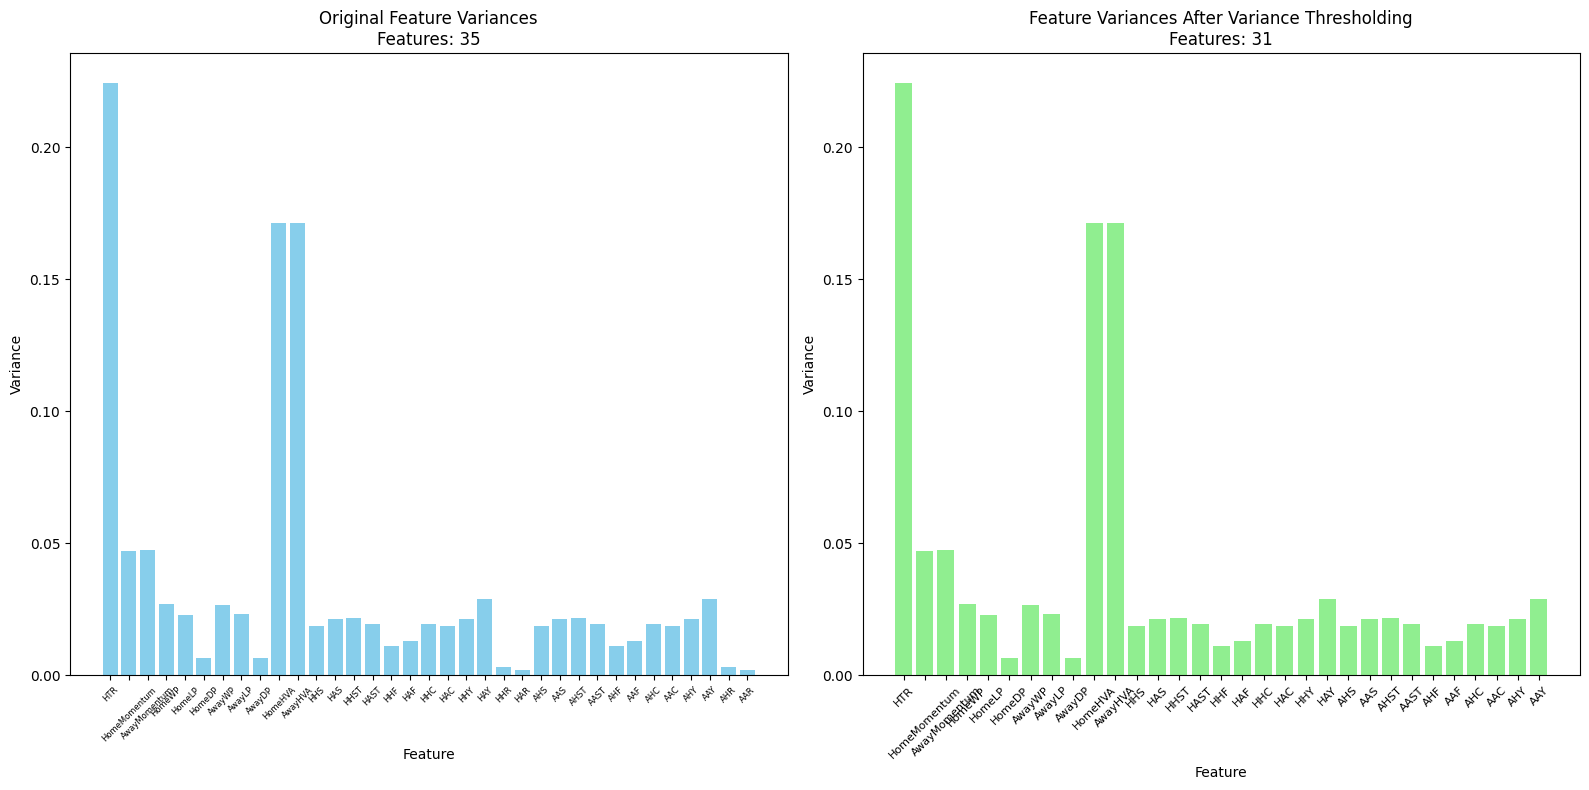

Number of features before variance threshold: 35
Number of features after variance threshold: 31


In [21]:
# variance threshold ofr NO_HTR
threshold = 0.005
selector_htr = VarianceThreshold(threshold)

X_train_htr_selected = selector_htr.fit_transform(X_train_htr) # X_train_htr
X_test_htr_selected = selector_htr.transform(X_test_htr)

# original features
variances_train_htr_original = np.var(X_train_htr, axis=0)
# selected features
variances_train_htr_selected = np.var(X_train_htr_selected, axis=0)

# feature_names_htr comes from above jupyter cells
num_features_before = X_train_htr.shape[1]
num_features_after = X_train_htr_selected.shape[1]

plt.figure(figsize=(16, 8))

# original
plt.subplot(1, 2, 1)
plt.bar(feature_names_htr, variances_train_htr_original, color='skyblue')
plt.title(f'Original Feature Variances\nFeatures: {num_features_before}')
plt.xlabel('Feature')
plt.ylabel('Variance')
plt.xticks(rotation=45 , fontsize=6)

# selected
plt.subplot(1, 2, 2)
plt.bar(feature_names_htr[selector_htr.get_support()], variances_train_htr_selected, color='lightgreen')
plt.title(f'Feature Variances After Variance Thresholding\nFeatures: {num_features_after}')
plt.xlabel('Feature')
plt.ylabel('Variance')
plt.xticks(rotation=45, fontsize=8)

plt.tight_layout()
plt.show()

print(f"Number of features before variance threshold: {num_features_before}")
print(f"Number of features after variance threshold: {num_features_after}")


## Variance Threshold Done
## Now doing feature extraction.


#LDA

In [22]:
# Apply LDA, reduce to 1 component since binary classification
# used LDA since we have labels
lda_no_htr = LDA(n_components=1)
X_train_no_htr_lda = lda_no_htr.fit_transform(X_train_no_htr_selected, y_train_no_htr)
X_test_no_htr_lda = lda_no_htr.transform(X_test_no_htr_selected)

# print("Explained variance ratio (no_htr):", lda_no_htr.explained_variance_ratio_)

In [23]:
lda_htr = LDA(n_components=1)
X_train_htr_lda = lda_htr.fit_transform(X_train_htr_selected, y_train_htr)
X_test_htr_lda = lda_htr.transform(X_test_htr_selected)

# print("Explained variance ratio (htr):", lda_htr.explained_variance_ratio_)

#PCA

In [24]:
# PCA
pca_no_htr = PCA(n_components=0.7)  # Retain 50%
X_train_no_htr_pca = pca_no_htr.fit_transform(X_train_no_htr_selected)
X_test_no_htr_pca = pca_no_htr.transform(X_test_no_htr_selected)

print(f"Number of components (no_HTR): {pca_no_htr.n_components_}")
print(f"Explained variance ratio (no_HTR): {pca_no_htr.explained_variance_ratio_}")
print(f"Shape of X_train_no_htr_pca: {X_train_no_htr_pca.shape}")


Number of components (no_HTR): 4
Explained variance ratio (no_HTR): [0.40060244 0.1770307  0.07764187 0.0741016 ]
Shape of X_train_no_htr_pca: (3040, 4)


In [25]:
pca_htr = PCA(n_components=0.7)
X_train_htr_pca = pca_htr.fit_transform(X_train_htr_selected)
X_test_htr_pca = pca_htr.transform(X_test_htr_selected)

print(f"Number of components (HTR): {pca_htr.n_components_}")
print(f"Explained variance ratio (HTR): {pca_htr.explained_variance_ratio_}")
print(f"Shape of X_train_htr_pca: {X_train_htr_pca.shape}")


Number of components (HTR): 4
Explained variance ratio (HTR): [0.33324849 0.19298428 0.13499312 0.06123262]
Shape of X_train_htr_pca: (3040, 4)


##Extraction Done
##Next is l1, l2

SVM Train Accuracy: 0.6578947368421053
SVM Test Accuracy: 0.6666666666666666


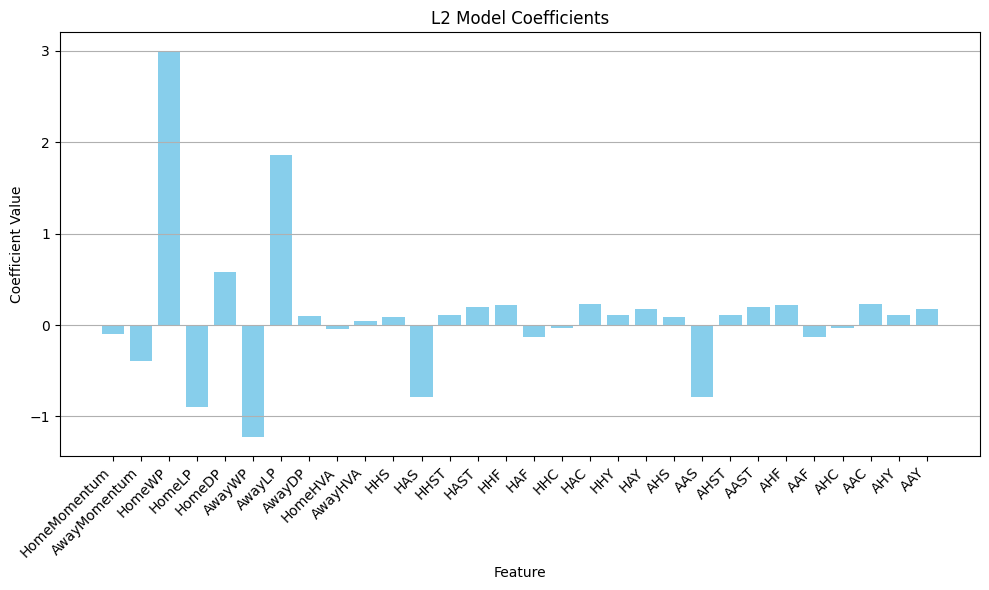

In [26]:
# L2 Regularization (Ridge) # variance threshold
l2_svm_model = SVC(kernel='linear', C=10.0, random_state=0)
l2_svm_model.fit(X_train_no_htr_selected, y_train_no_htr)
y_pred_l2_svm = l2_svm_model.predict(X_test_no_htr_selected)
print("SVM Train Accuracy:", accuracy_score(y_train_no_htr, l2_svm_model.predict(X_train_no_htr_selected)))
print("SVM Test Accuracy:", accuracy_score(y_test_no_htr, y_pred_l2_svm))

plt.figure(figsize=(10, 6))
plt.bar(feature_names_no_htr[selector_no_htr.get_support()], l2_svm_model.coef_[0], color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Coefficient Value')
plt.title('L2 Model Coefficients')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

SVM Train Accuracy: 0.6578947368421053
SVM Test Accuracy: 0.6650641025641025


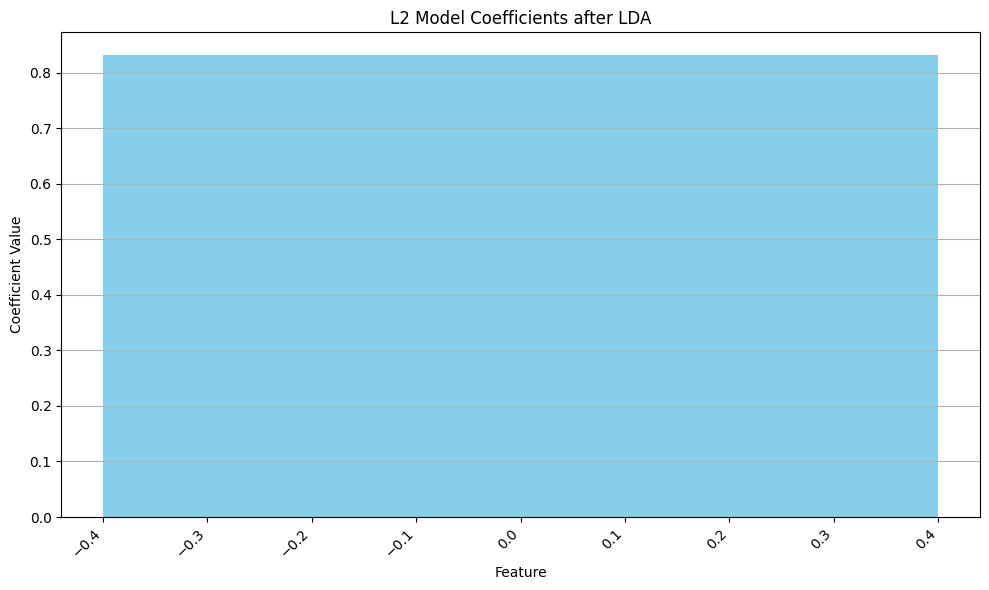

In [27]:
# L2 Regularization (Ridge) # lda
l2_svm_model_lda = SVC(kernel='linear', C=10.0, random_state=0)
l2_svm_model_lda.fit(X_train_no_htr_lda, y_train_no_htr)
y_pred_l2_svm_lda = l2_svm_model_lda.predict(X_test_no_htr_lda)
print("SVM Train Accuracy:", accuracy_score(y_train_no_htr, l2_svm_model_lda.predict(X_train_no_htr_lda)))
print("SVM Test Accuracy:", accuracy_score(y_test_no_htr, y_pred_l2_svm_lda))

# number of features should be 1 now!
plt.figure(figsize=(10, 6))
plt.bar(range(len(l2_svm_model_lda.coef_[0])), l2_svm_model_lda.coef_[0], color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Coefficient Value')
plt.title('L2 Model Coefficients after LDA')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

SVM Train Accuracy: 0.6401315789473684
SVM Test Accuracy: 0.6426282051282052


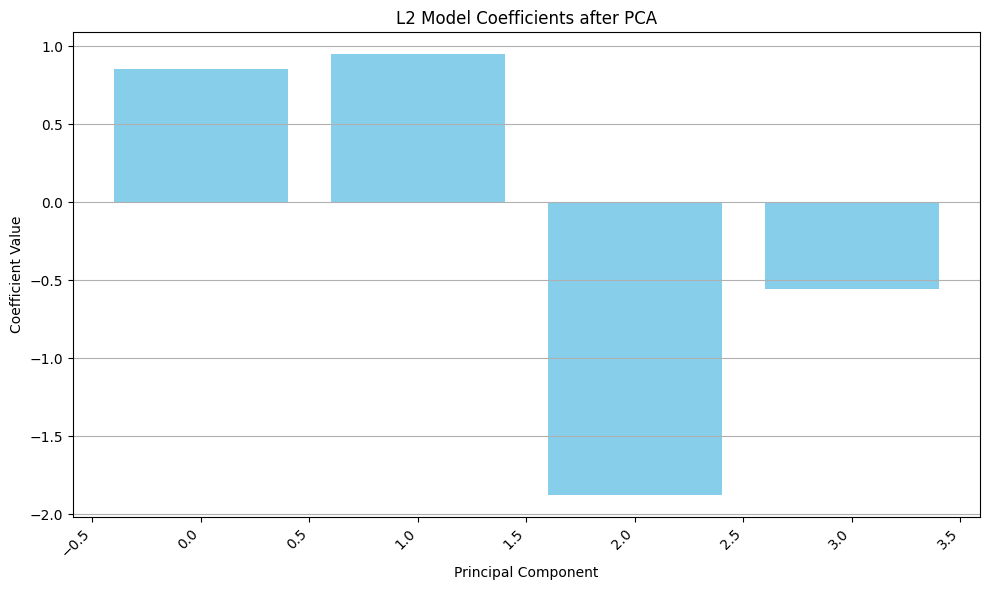

In [28]:
# L2 Regularization (Ridge) # PCA
l2_svm_model_pca = SVC(kernel='linear', C=10.0, random_state=0)
l2_svm_model_pca.fit(X_train_no_htr_pca, y_train_no_htr)
y_pred_l2_svm_pca = l2_svm_model_pca.predict(X_test_no_htr_pca)
print("SVM Train Accuracy:", accuracy_score(y_train_no_htr, l2_svm_model_pca.predict(X_train_no_htr_pca)))
print("SVM Test Accuracy:", accuracy_score(y_test_no_htr, y_pred_l2_svm_pca))

# Graph: Plot the coefficients from the L2 model after PCA
plt.figure(figsize=(10, 6))
plt.bar(range(len(l2_svm_model_pca.coef_[0])), l2_svm_model_pca.coef_[0], color='skyblue')
plt.xlabel('Principal Component')
plt.ylabel('Coefficient Value')
plt.title('L2 Model Coefficients after PCA')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

SVM Train Accuracy: 0.6592105263157895
SVM Test Accuracy: 0.6698717948717948
SVM Train F1 Score: 0.580906148867314
SVM Test F1 Score: 0.6007751937984496


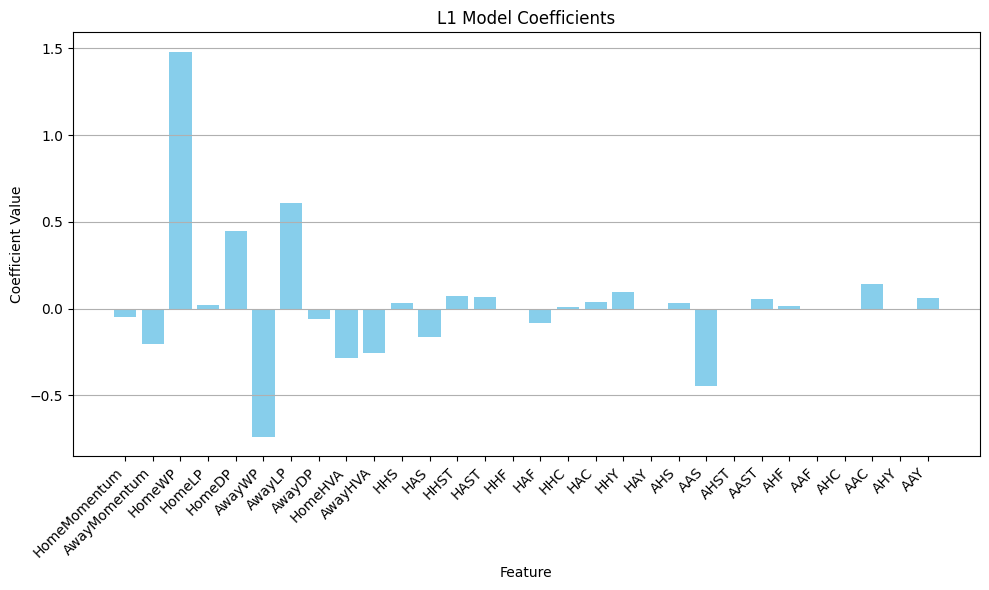

In [29]:
# L1 Regularization using linearSVC so I can use l1
l1_svm_model = LinearSVC(penalty='l1', C=10.0, random_state=0, max_iter=3500) # 100 works better
l1_svm_model.fit(X_train_no_htr_selected, y_train_no_htr)
y_pred_l1_svm = l1_svm_model.predict(X_test_no_htr_selected)
y_pred_l1_train_svm = l1_svm_model.predict(X_train_no_htr_selected)

print("SVM Train Accuracy:", accuracy_score(y_train_no_htr, y_pred_l1_train_svm))
print("SVM Test Accuracy:", accuracy_score(y_test_no_htr, y_pred_l1_svm))

print("SVM Train F1 Score:", f1_score(y_train_no_htr, y_pred_l1_train_svm))
print("SVM Test F1 Score:", f1_score(y_test_no_htr, y_pred_l1_svm))

plt.figure(figsize=(10, 6))
plt.bar(feature_names_no_htr[selector_no_htr.get_support()], l1_svm_model.coef_[0], color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Coefficient Value')
plt.title('L1 Model Coefficients')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

Accuracy: 0.6592105263157895
Precision: 0.6564656465646564
Recall: 0.6467426860482977
F1 Score: 0.6468832296443


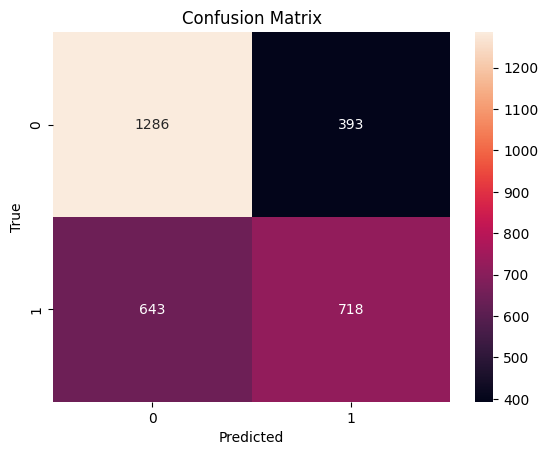

In [30]:
print_cm(y_train_no_htr, l1_svm_model.predict(X_train_no_htr_selected), 'macro')

              precision    recall  f1-score   support

           0       0.69      0.75      0.72       350
           1       0.64      0.57      0.60       274

    accuracy                           0.67       624
   macro avg       0.66      0.66      0.66       624
weighted avg       0.67      0.67      0.67       624

Accuracy: 0.6698717948717948
Precision: 0.6644887715806326
Recall: 0.658561001042753
F1 Score: 0.6596772143855636


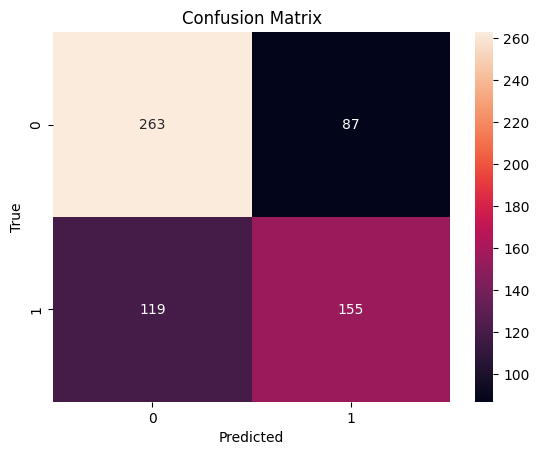

In [31]:
print_cm(y_test_no_htr, y_pred_l1_svm, 'macro', class_report=True)

SVM Train Accuracy: 0.6592105263157895
SVM Test Accuracy: 0.6698717948717948
SVM Train F1 Score: 0.5812449474535166
SVM Test F1 Score: 0.6007751937984496


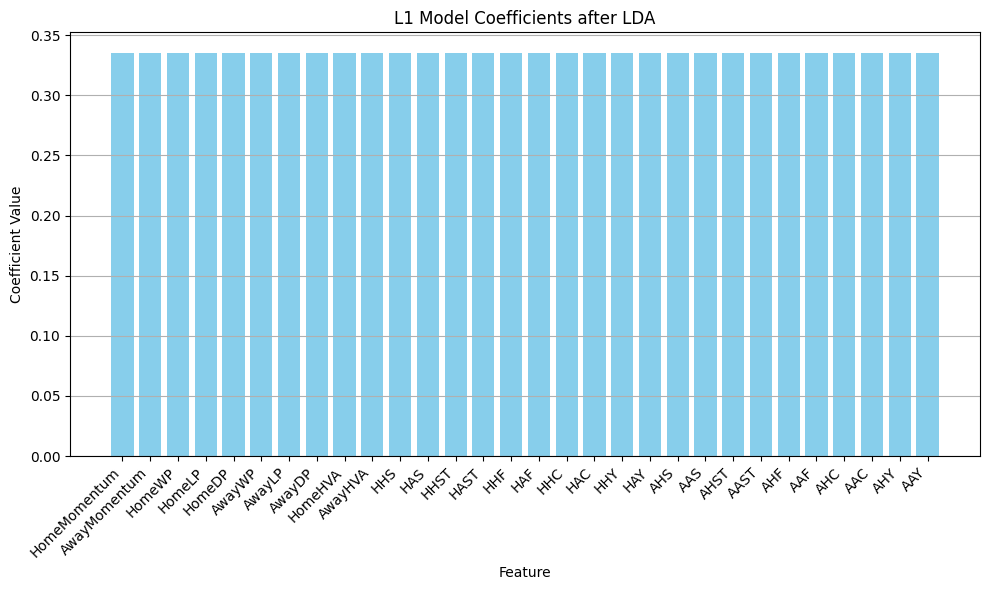

In [32]:
# L1 Regularization using LinearSVC after LDA
l1_svm_model_lda = LinearSVC(penalty='l1', C=10.0, random_state=0, max_iter=3500)
l1_svm_model_lda.fit(X_train_no_htr_lda, y_train_no_htr)
y_pred_l1_svm_lda = l1_svm_model_lda.predict(X_test_no_htr_lda)
y_pred_l1_train_svm_lda = l1_svm_model_lda.predict(X_train_no_htr_lda)

print("SVM Train Accuracy:", accuracy_score(y_train_no_htr, y_pred_l1_train_svm_lda))
print("SVM Test Accuracy:", accuracy_score(y_test_no_htr, y_pred_l1_svm_lda))

print("SVM Train F1 Score:", f1_score(y_train_no_htr, y_pred_l1_train_svm_lda))
print("SVM Test F1 Score:", f1_score(y_test_no_htr, y_pred_l1_svm_lda))

# Plot L1 Model Coefficients after LDA
plt.figure(figsize=(10, 6))
plt.bar(feature_names_no_htr[selector_no_htr.get_support()], l1_svm_model_lda.coef_[0], color='skyblue') # range(len(l2_svm_model_lda.coef_[0]))
plt.xlabel('Feature')
plt.ylabel('Coefficient Value')
plt.title('L1 Model Coefficients after LDA')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

SVM Train Accuracy: 0.6588815789473684
SVM Test Accuracy: 0.6682692307692307
SVM Train F1 Score: 0.5806712494945411
SVM Test F1 Score: 0.5980582524271845


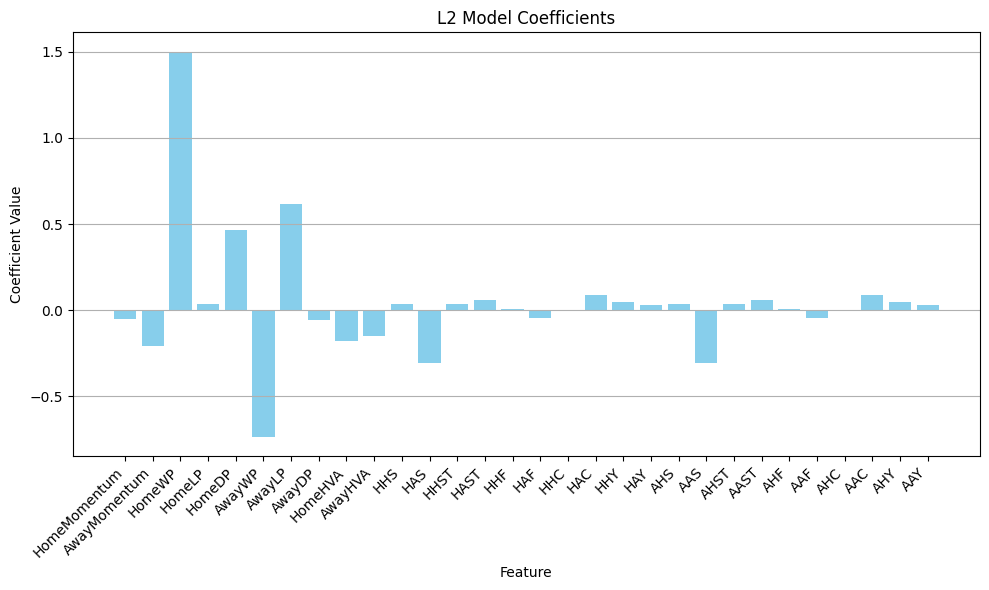

In [33]:
# L2 Regularization using linearSVC
l2_svm_model_2 = LinearSVC(penalty='l2', C=10.0, random_state=0, max_iter=3500) # 100 works better
l2_svm_model_2.fit(X_train_no_htr_selected, y_train_no_htr)
y_pred_l2_svm_2 = l2_svm_model_2.predict(X_test_no_htr_selected)
y_pred_l2_train_svm_2 = l2_svm_model_2.predict(X_train_no_htr_selected)

print("SVM Train Accuracy:", accuracy_score(y_train_no_htr, y_pred_l2_train_svm_2))
print("SVM Test Accuracy:", accuracy_score(y_test_no_htr, y_pred_l2_svm_2))

print("SVM Train F1 Score:", f1_score(y_train_no_htr, y_pred_l2_train_svm_2))
print("SVM Test F1 Score:", f1_score(y_test_no_htr, y_pred_l2_svm_2))

plt.figure(figsize=(10, 6))
plt.bar(feature_names_no_htr[selector_no_htr.get_support()], l2_svm_model_2.coef_[0], color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Coefficient Value')
plt.title('L2 Model Coefficients')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

Tried SVM

LDA didnt really do much!

Guess I'll try CPA

TODO:
- add feature extraction
- try the exact same thing above with HTR
- clean code

- try all of this again on multiple models

In [34]:
# L1 Regularization using linearSVC so I can use l1 same from above
l1_svm_model = LinearSVC(penalty='l1', C=10.0, random_state=0, max_iter=3500) # 100 works better
l1_svm_model.fit(X_train_no_htr_selected, y_train_no_htr)
y_pred_l1_svm = l1_svm_model.predict(X_test_no_htr_selected)
y_pred_l1_train_svm = l1_svm_model.predict(X_train_no_htr_selected)

print("SVM Train Accuracy:", accuracy_score(y_train_no_htr, y_pred_l1_train_svm))
print("SVM Test Accuracy:", accuracy_score(y_test_no_htr, y_pred_l1_svm))

print("SVM Train F1 Score:", f1_score(y_train_no_htr, y_pred_l1_train_svm))
print("SVM Test F1 Score:", f1_score(y_test_no_htr, y_pred_l1_svm))

SVM Train Accuracy: 0.6592105263157895
SVM Test Accuracy: 0.6698717948717948
SVM Train F1 Score: 0.580906148867314
SVM Test F1 Score: 0.6007751937984496


In [35]:
#hyperparam tuning
#grid search isnt really workign I'm getting better results
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [10.0],
    'max_iter': [3500, 5000],
    'penalty': ['l1', 'l2']
}

l1_svm = LinearSVC(dual=False, random_state=0)

grid_search = GridSearchCV(estimator=l1_svm, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_no_htr_selected, y_train_no_htr)

best_params = grid_search.best_params_
print("Best Parameters from Grid Search:", best_params)

best_l1_svm_model = grid_search.best_estimator_

y_pred_l1_svm = best_l1_svm_model.predict(X_test_no_htr_selected)
y_pred_l1_train_svm = best_l1_svm_model.predict(X_train_no_htr_selected)

print("SVM Train Accuracy:", accuracy_score(y_train_no_htr, y_pred_l1_train_svm))
print("SVM Test Accuracy:", accuracy_score(y_test_no_htr, y_pred_l1_svm))

print("SVM Train F1 Score:", f1_score(y_train_no_htr, y_pred_l1_train_svm))
print("SVM Test F1 Score:", f1_score(y_test_no_htr, y_pred_l1_svm))

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Best Parameters from Grid Search: {'C': 10.0, 'max_iter': 3500, 'penalty': 'l2'}
SVM Train Accuracy: 0.6588815789473684
SVM Test Accuracy: 0.6682692307692307
SVM Train F1 Score: 0.5806712494945411
SVM Test F1 Score: 0.5980582524271845


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


---

In [36]:
l1_svm_model = SVC(kernel='linear', C=1.0, probability=True, random_state=0, max_iter=-1)
l1_svm_model.fit(X_train_no_htr_selected, y_train_no_htr)

y_pred_l1_svm = l1_svm_model.predict(X_test_no_htr_selected)
y_pred_l1_train_svm = l1_svm_model.predict(X_train_no_htr_selected)

print("SVM Train Accuracy:", accuracy_score(y_train_no_htr, y_pred_l1_train_svm))
print("SVM Test Accuracy:", accuracy_score(y_test_no_htr, y_pred_l1_svm))

print("SVM Train F1 Score:", f1_score(y_train_no_htr, y_pred_l1_train_svm))
print("SVM Test F1 Score:", f1_score(y_test_no_htr, y_pred_l1_svm))


SVM Train Accuracy: 0.6536184210526316
SVM Test Accuracy: 0.6682692307692307
SVM Train F1 Score: 0.56143273635985
SVM Test F1 Score: 0.6026871401151631


In [37]:
l1_svm_model2 = SVC(kernel='linear', C=1.0, probability=True, random_state=0, max_iter=-1)
l1_svm_model2.fit(X_train_no_htr_lda, y_train_no_htr)

y_pred_l1_svm2 = l1_svm_model2.predict(X_test_no_htr_lda)
y_pred_l1_train_svm2 = l1_svm_model2.predict(X_train_no_htr_lda)

print("SVM Train Accuracy:", accuracy_score(y_train_no_htr, y_pred_l1_train_svm2))
print("SVM Test Accuracy:", accuracy_score(y_test_no_htr, y_pred_l1_svm2))

print("SVM Train F1 Score:", f1_score(y_train_no_htr, y_pred_l1_train_svm2))
print("SVM Test F1 Score:", f1_score(y_test_no_htr, y_pred_l1_svm2))


SVM Train Accuracy: 0.6578947368421053
SVM Test Accuracy: 0.6650641025641025
SVM Train F1 Score: 0.5734208367514356
SVM Test F1 Score: 0.5893909626719057


In [38]:
l1_svm_model3 = SVC(kernel='linear', C=1.0, probability=True, random_state=0, max_iter=-1)
l1_svm_model3.fit(X_train_no_htr_pca, y_train_no_htr)

y_pred_l1_svm3 = l1_svm_model3.predict(X_test_no_htr_pca)
y_pred_l1_train_svm3 = l1_svm_model3.predict(X_train_no_htr_pca)

print("SVM Train Accuracy:", accuracy_score(y_train_no_htr, y_pred_l1_train_svm3))
print("SVM Test Accuracy:", accuracy_score(y_test_no_htr, y_pred_l1_svm3))

print("SVM Train F1 Score:", f1_score(y_train_no_htr, y_pred_l1_train_svm3))
print("SVM Test F1 Score:", f1_score(y_test_no_htr, y_pred_l1_svm3))


SVM Train Accuracy: 0.6398026315789473
SVM Test Accuracy: 0.6426282051282052
SVM Train F1 Score: 0.5550589191385615
SVM Test F1 Score: 0.5703275529865125


In [39]:
# #voting
# # Soft Voting
# base_models = [
#     ('svm1', l1_svm_model),
#     ('svm2', l1_svm_model2),
#     ('svm3', l1_svm_model3),
# ]

# soft_voting_model = VotingClassifier(estimators=base_models, voting='soft')  # using soft voting
# soft_voting_model.fit(X_train_no_htr_selected, y_train_no_htr)

# y_train_pred = soft_voting_model.predict(X_train_no_htr_selected)
# y_test_pred = soft_voting_model.predict(X_test_no_htr_selected)

# accuracy_train_soft = accuracy_score(y_train_no_htr, y_train_pred)
# accuracy_test_soft = accuracy_score(y_train_no_htr, y_test_pred)

# print("Soft Voting Model Accuracy (Training):", accuracy_train_soft * 100)
# print("Soft Voting Model Accuracy (Testing):", accuracy_test_soft * 100)

# issue with svm and probabilities for soft voting


In [40]:
#stacking
base_models = [
    ('svm1', l1_svm_model),
    ('svm2', l1_svm_model2),
    ('svm3', l1_svm_model3),
]

meta_model = SVC(kernel='linear', C=1.0, probability=True, random_state=0, max_iter=-1)
stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

stacked_model.fit(X_train_no_htr_selected, y_train_no_htr)

y_pred_l1_svm_stacked = stacked_model.predict(X_test_no_htr_selected)
y_pred_l1_train_svm_stacked = stacked_model.predict(X_train_no_htr_selected)

print("SVM Train Accuracy:", accuracy_score(y_train_no_htr, y_pred_l1_train_svm_stacked))
print("SVM Test Accuracy:", accuracy_score(y_test_no_htr, y_pred_l1_svm_stacked))

print("SVM Train F1 Score:", f1_score(y_train_no_htr, y_pred_l1_train_svm_stacked))
print("SVM Test F1 Score:", f1_score(y_test_no_htr, y_pred_l1_svm_stacked))

SVM Train Accuracy: 0.655921052631579
SVM Test Accuracy: 0.6666666666666666
SVM Train F1 Score: 0.5663349917081261
SVM Test F1 Score: 0.6015325670498084


In [83]:
l1_svm_model = SVC(kernel='linear', C=10.0, probability=True, random_state=0, max_iter=-1)
l1_svm_model.fit(X_train_htr_selected, y_train_htr)

y_pred_l1_svm = l1_svm_model.predict(X_test_htr_selected)
y_pred_l1_train_svm = l1_svm_model.predict(X_train_htr_selected)

print("SVM Train Accuracy:", accuracy_score(y_train_htr, y_pred_l1_train_svm))
print("SVM Test Accuracy:", accuracy_score(y_test_htr, y_pred_l1_svm))

print("SVM Train F1 Score:", f1_score(y_train_htr, y_pred_l1_train_svm))
print("SVM Test F1 Score:", f1_score(y_test_htr, y_pred_l1_svm))

SVM Train Accuracy: 0.7595394736842105
SVM Test Accuracy: 0.7163461538461539
SVM Train F1 Score: 0.6947807933194154
SVM Test F1 Score: 0.6424242424242425


In [84]:
l1_svm_model2 = SVC(kernel='linear', C=10.0, probability=True, random_state=0, max_iter=-1)
l1_svm_model2.fit(X_train_htr_lda, y_train_htr)

y_pred_l1_svm2 = l1_svm_model2.predict(X_test_htr_lda)
y_pred_l1_train_svm2 = l1_svm_model2.predict(X_train_htr_lda)

print("SVM Train Accuracy:", accuracy_score(y_train_htr, y_pred_l1_train_svm2))
print("SVM Test Accuracy:", accuracy_score(y_test_htr, y_pred_l1_svm2))

print("SVM Train F1 Score:", f1_score(y_train_htr, y_pred_l1_train_svm2))
print("SVM Test F1 Score:", f1_score(y_test_htr, y_pred_l1_svm2))


SVM Train Accuracy: 0.7631578947368421
SVM Test Accuracy: 0.7227564102564102
SVM Train F1 Score: 0.7032151690024732
SVM Test F1 Score: 0.6560636182902585


In [43]:
l1_svm_model3 = SVC(kernel='linear', C=10.0, probability=True, random_state=0, max_iter=-1)
l1_svm_model3.fit(X_train_htr_pca, y_train_no_htr)

y_pred_l1_svm3 = l1_svm_model3.predict(X_test_htr_pca)
y_pred_l1_train_svm3 = l1_svm_model3.predict(X_train_htr_pca)

print("SVM Train Accuracy:", accuracy_score(y_train_no_htr, y_pred_l1_train_svm3))
print("SVM Test Accuracy:", accuracy_score(y_test_no_htr, y_pred_l1_svm3))

print("SVM Train F1 Score:", f1_score(y_train_no_htr, y_pred_l1_train_svm3))
print("SVM Test F1 Score:", f1_score(y_test_no_htr, y_pred_l1_svm3))


SVM Train Accuracy: 0.7595394736842105
SVM Test Accuracy: 0.7163461538461539
SVM Train F1 Score: 0.6947807933194154
SVM Test F1 Score: 0.6424242424242425


In [85]:
logreg_model = LogisticRegression(random_state=0, max_iter=3500)
logreg_model.fit(X_train_htr_selected, y_train_htr)

y_pred_logreg = logreg_model.predict(X_test_htr_selected)
y_pred_logreg_train = logreg_model.predict(X_train_htr_selected)

print("Logistic Regression Train Accuracy:", accuracy_score(y_train_htr, y_pred_logreg_train))
print("Logistic Regression Test Accuracy:", accuracy_score(y_test_htr, y_pred_logreg))

print("Logistic Regression Train F1 Score:", f1_score(y_train_htr, y_pred_logreg_train))
print("Logistic Regression Test F1 Score:", f1_score(y_test_htr, y_pred_logreg))

Logistic Regression Train Accuracy: 0.7625
Logistic Regression Test Accuracy: 0.7243589743589743
Logistic Regression Train F1 Score: 0.7107371794871795
Logistic Regression Test F1 Score: 0.667953667953668


In [86]:
logreg_model2 = LogisticRegression(random_state=0, max_iter=3500)
logreg_model2.fit(X_train_htr_lda, y_train_htr)

y_pred_logreg2 = logreg_model2.predict(X_test_htr_lda)
y_pred_logreg2_train = logreg_model2.predict(X_train_htr_lda)

print("Logistic Regression Train Accuracy:", accuracy_score(y_train_htr, y_pred_logreg2_train))
print("Logistic Regression Test Accuracy:", accuracy_score(y_test_htr, y_pred_logreg2))

print("Logistic Regression Train F1 Score:", f1_score(y_train_htr, y_pred_logreg2_train))
print("Logistic Regression Test F1 Score:", f1_score(y_test_htr, y_pred_logreg2))


Logistic Regression Train Accuracy: 0.7638157894736842
Logistic Regression Test Accuracy: 0.7259615384615384
Logistic Regression Train F1 Score: 0.7078925956061839
Logistic Regression Test F1 Score: 0.6627218934911243


In [88]:
logreg_model = LogisticRegression(random_state=0, max_iter=100)
logreg_model.fit(X_train_htr_pca, y_train_htr)

y_pred_logreg = logreg_model.predict(X_test_htr_pca)
y_pred_logreg_train = logreg_model.predict(X_train_htr_pca)

print("Logistic Regression Train Accuracy:", accuracy_score(y_train_htr, y_pred_logreg_train))
print("Logistic Regression Test Accuracy:", accuracy_score(y_test_htr, y_pred_logreg))

print("Logistic Regression Train F1 Score:", f1_score(y_train_htr, y_pred_logreg_train))
print("Logistic Regression Test F1 Score:", f1_score(y_test_htr, y_pred_logreg))

Logistic Regression Train Accuracy: 0.7615131578947368
Logistic Regression Test Accuracy: 0.7307692307692307
Logistic Regression Train F1 Score: 0.7027470274702747
Logistic Regression Test F1 Score: 0.6756756756756757


PCA works best on log but not svm or other models?

In [98]:
# Random Forest for X_train_htr_selected
rf_model1 = RandomForestClassifier(max_depth=5, random_state=0)
rf_model1.fit(X_train_htr_selected, y_train_htr)

y_pred_rf1 = rf_model1.predict(X_test_htr_selected)
y_pred_rf1_train = rf_model1.predict(X_train_htr_selected)

print("Random Forest Train Accuracy (HTR selected):", accuracy_score(y_train_htr, y_pred_rf1_train))
print("Random Forest Test Accuracy (HTR selected):", accuracy_score(y_test_htr, y_pred_rf1))
print("Random Forest Train F1 Score (HTR selected):", f1_score(y_train_htr, y_pred_rf1_train))
print("Random Forest Test F1 Score (HTR selected):", f1_score(y_test_htr, y_pred_rf1))

Random Forest Train Accuracy (HTR selected): 0.7845394736842105
Random Forest Test Accuracy (HTR selected): 0.7323717948717948
Random Forest Train F1 Score (HTR selected): 0.7422274695001968
Random Forest Test F1 Score (HTR selected): 0.6757281553398058


In [96]:
# Random Forest for X_train_htr_lda
rf_model2 = RandomForestClassifier(max_depth=1, random_state=0)
rf_model2.fit(X_train_htr_lda, y_train_no_htr)

y_pred_rf2 = rf_model2.predict(X_test_htr_lda)
y_pred_rf2_train = rf_model2.predict(X_train_htr_lda)

print("Random Forest Train Accuracy (HTR LDA):", accuracy_score(y_train_no_htr, y_pred_rf2_train))
print("Random Forest Test Accuracy (HTR LDA):", accuracy_score(y_test_no_htr, y_pred_rf2))
print("Random Forest Train F1 Score (HTR LDA):", f1_score(y_train_no_htr, y_pred_rf2_train))
print("Random Forest Test F1 Score (HTR LDA):", f1_score(y_test_no_htr, y_pred_rf2))

Random Forest Train Accuracy (HTR LDA): 0.7674342105263158
Random Forest Test Accuracy (HTR LDA): 0.7323717948717948
Random Forest Train F1 Score (HTR LDA): 0.7290149482560367
Random Forest Test F1 Score (HTR LDA): 0.6935779816513762


overfitting but still lowering max epth doesnt really help to get 70%+

In [95]:
# Random Forest for X_train_no_htr_pca
rf_model3 = RandomForestClassifier(max_depth=1, random_state=0)
rf_model3.fit(X_train_htr_pca, y_train_no_htr)

y_pred_rf3 = rf_model3.predict(X_test_htr_pca)
y_pred_rf3_train = rf_model3.predict(X_train_htr_pca)

print("Random Forest Train Accuracy (HTR PCA):", accuracy_score(y_train_htr, y_pred_rf3_train))
print("Random Forest Test Accuracy (HTR PCA):", accuracy_score(y_test_htr, y_pred_rf3))
print("Random Forest Train F1 Score (HTR PCA):", f1_score(y_train_htr, y_pred_rf3_train))
print("Random Forest Test F1 Score (HTR PCA):", f1_score(y_test_htr, y_pred_rf3))

Random Forest Train Accuracy (HTR PCA): 0.7582236842105263
Random Forest Test Accuracy (HTR PCA): 0.7147435897435898
Random Forest Train F1 Score (HTR PCA): 0.6953999171156237
Random Forest Test F1 Score (HTR PCA): 0.642570281124498


In [60]:
# Decision Tree Classifier for X_train_htr_selected
from sklearn.tree import DecisionTreeClassifier

dt_model1 = DecisionTreeClassifier(max_depth=1, random_state=0)
dt_model1.fit(X_train_htr_selected, y_train_no_htr)

y_pred_dt1 = dt_model1.predict(X_test_htr_selected)
y_pred_dt1_train = dt_model1.predict(X_train_htr_selected)

print("Decision Tree Train Accuracy (HTR selected):", accuracy_score(y_train_no_htr, y_pred_dt1_train))
print("Decision Tree Test Accuracy (HTR selected):", accuracy_score(y_test_no_htr, y_pred_dt1))
print("Decision Tree Train F1 Score (HTR selected):", f1_score(y_train_no_htr, y_pred_dt1_train))
print("Decision Tree Test F1 Score (HTR selected):", f1_score(y_test_no_htr, y_pred_dt1))


Decision Tree Train Accuracy (HTR selected): 0.7595394736842105
Decision Tree Test Accuracy (HTR selected): 0.7163461538461539
Decision Tree Train F1 Score (HTR selected): 0.6947807933194154
Decision Tree Test F1 Score (HTR selected): 0.6424242424242425


about the same now

In [63]:
dt_model2 = DecisionTreeClassifier(max_depth=1, random_state=0)
dt_model2.fit(X_train_htr_lda, y_train_no_htr)

y_pred_dt2 = dt_model2.predict(X_test_htr_lda)
y_pred_dt2_train = dt_model2.predict(X_train_htr_lda)

print("Decision Tree Train Accuracy (HTR LDA):", accuracy_score(y_train_no_htr, y_pred_dt2_train))
print("Decision Tree Test Accuracy (HTR LDA):", accuracy_score(y_test_no_htr, y_pred_dt2))

print("Decision Tree Train F1 Score (HTR LDA):", f1_score(y_train_no_htr, y_pred_dt2_train))
print("Decision Tree Test F1 Score (HTR LDA):", f1_score(y_test_no_htr, y_pred_dt2))

Decision Tree Train Accuracy (HTR LDA): 0.7684210526315789
Decision Tree Test Accuracy (HTR LDA): 0.7275641025641025
Decision Tree Train F1 Score (HTR LDA): 0.7327258921791951
Decision Tree Test F1 Score (HTR LDA): 0.6909090909090909


In [67]:
# Decision Tree Classifier for X_train_no_htr_selected
dt_model3 = DecisionTreeClassifier(max_depth=2, random_state=0)
dt_model3.fit(X_train_htr_pca, y_train_no_htr)

y_pred_dt3 = dt_model3.predict(X_test_htr_pca)
y_pred_dt3_train = dt_model3.predict(X_train_htr_pca)

print("Decision Tree Train Accuracy (PCA):", accuracy_score(y_train_no_htr, y_pred_dt3_train))
print("Decision Tree Test Accuracy (PCA):", accuracy_score(y_test_no_htr, y_pred_dt3))
print("Decision Tree Train F1 Score (PCA):", f1_score(y_train_no_htr, y_pred_dt3_train))
print("Decision Tree Test F1 Score (PCA):", f1_score(y_test_no_htr, y_pred_dt3))

Decision Tree Train Accuracy (PCA): 0.7582236842105263
Decision Tree Test Accuracy (PCA): 0.717948717948718
Decision Tree Train F1 Score (PCA): 0.6971569839307787
Decision Tree Test F1 Score (PCA): 0.648


In [100]:
ada_dt_model1 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=50, random_state=0)
ada_dt_model1.fit(X_train_htr_selected, y_train_no_htr)

y_pred_ada_dt1 = ada_dt_model1.predict(X_test_htr_selected)
y_pred_ada_dt1_train = ada_dt_model1.predict(X_train_htr_selected)

print("AdaBoost (DT) Train Accuracy (HTR selected):", accuracy_score(y_train_no_htr, y_pred_ada_dt1_train))
print("AdaBoost (DT) Test Accuracy (HTR selected):", accuracy_score(y_test_no_htr, y_pred_ada_dt1))
print("AdaBoost (DT) Train F1 Score (HTR selected):", f1_score(y_train_no_htr, y_pred_ada_dt1_train))
print("AdaBoost (DT) Test F1 Score (HTR selected):", f1_score(y_test_no_htr, y_pred_ada_dt1))

AdaBoost (DT) Train Accuracy (HTR selected): 0.7657894736842106
AdaBoost (DT) Test Accuracy (HTR selected): 0.7435897435897436
AdaBoost (DT) Train F1 Score (HTR selected): 0.7194641449960599
AdaBoost (DT) Test F1 Score (HTR selected): 0.700374531835206


In [76]:
ada_dt_model2 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=50, random_state=0)
ada_dt_model2.fit(X_train_htr_lda, y_train_no_htr)

y_pred_ada_dt2 = ada_dt_model2.predict(X_test_htr_lda)
y_pred_ada_dt2_train = ada_dt_model2.predict(X_train_htr_lda)

print("AdaBoost (DT) Train Accuracy (HTR LDA):", accuracy_score(y_train_no_htr, y_pred_ada_dt2_train))
print("AdaBoost (DT) Test Accuracy (HTR LDA):", accuracy_score(y_test_no_htr, y_pred_ada_dt2))
print("AdaBoost (DT) Train F1 Score (HTR selected):", f1_score(y_train_no_htr, y_pred_ada_dt2_train))
print("AdaBoost (DT) Test F1 Score (HTR selected):", f1_score(y_test_no_htr, y_pred_ada_dt2))

AdaBoost (DT) Train Accuracy (HTR LDA): 0.7684210526315789
AdaBoost (DT) Test Accuracy (HTR LDA): 0.7275641025641025
AdaBoost (DT) Train F1 Score (HTR selected): 0.7327258921791951
AdaBoost (DT) Test F1 Score (HTR selected): 0.6909090909090909


In [78]:
ada_dt_model3 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=50, random_state=0)
ada_dt_model3.fit(X_train_htr_pca, y_train_no_htr)

y_pred_ada_dt3 = ada_dt_model3.predict(X_test_htr_pca)
y_pred_ada_dt3_train = ada_dt_model3.predict(X_train_htr_pca)

print("AdaBoost (DT) Train Accuracy (No HTR selected):", accuracy_score(y_train_no_htr, y_pred_ada_dt3_train))
print("AdaBoost (DT) Test Accuracy (No HTR selected):", accuracy_score(y_test_no_htr, y_pred_ada_dt3))
print("AdaBoost (DT) Train F1 Score (No HTR selected):", f1_score(y_train_no_htr, y_pred_ada_dt3_train))
print("AdaBoost (DT) Test F1 Score (No HTR selected):", f1_score(y_test_no_htr, y_pred_ada_dt3))

AdaBoost (DT) Train Accuracy (No HTR selected): 0.7611842105263158
AdaBoost (DT) Test Accuracy (No HTR selected): 0.7227564102564102
AdaBoost (DT) Train F1 Score (No HTR selected): 0.7031888798037612
AdaBoost (DT) Test F1 Score (No HTR selected): 0.6587771203155819


In [89]:
ada_log_model1 = AdaBoostClassifier(LogisticRegression(solver='liblinear', max_iter=1000), n_estimators=50, random_state=0)
ada_log_model1.fit(X_train_htr_selected, y_train_htr)

y_pred_ada_log1 = ada_log_model1.predict(X_test_htr_selected)
y_pred_ada_log1_train = ada_log_model1.predict(X_train_htr_selected)

print("AdaBoost (Log) Train Accuracy (HTR selected):", accuracy_score(y_train_htr, y_pred_ada_log1_train))
print("AdaBoost (Log) Test Accuracy (HTR selected):", accuracy_score(y_test_htr, y_pred_ada_log1))
print("AdaBoost (Log) Train F1 Score (HTR selected):", f1_score(y_train_htr, y_pred_ada_log1_train))
print("AdaBoost (Log) Test F1 Score (HTR selected):", f1_score(y_test_htr, y_pred_ada_log1))

AdaBoost (Log) Train Accuracy (HTR selected): 0.7490131578947369
AdaBoost (Log) Test Accuracy (HTR selected): 0.7243589743589743
AdaBoost (Log) Train F1 Score (HTR selected): 0.7173027047054464
AdaBoost (Log) Test F1 Score (HTR selected): 0.6982456140350877


In [91]:
ada_log_model1 = AdaBoostClassifier(LogisticRegression(solver='liblinear', max_iter=1000), n_estimators=50, random_state=0)
ada_log_model1.fit(X_train_htr_lda, y_train_htr)

y_pred_ada_log1 = ada_log_model1.predict(X_test_htr_lda)
y_pred_ada_log1_train = ada_log_model1.predict(X_train_htr_lda)

print("AdaBoost (Log) Train Accuracy (LDA):", accuracy_score(y_train_htr, y_pred_ada_log1_train))
print("AdaBoost (Log) Test Accuracy (LDA):", accuracy_score(y_test_htr, y_pred_ada_log1))
print("AdaBoost (Log) Train F1 Score (LDA):", f1_score(y_train_htr, y_pred_ada_log1_train))
print("AdaBoost (Log) Test F1 Score (LDA):", f1_score(y_test_htr, y_pred_ada_log1))

AdaBoost (Log) Train Accuracy (LDA): 0.7644736842105263
AdaBoost (Log) Test Accuracy (LDA): 0.7259615384615384
AdaBoost (Log) Train F1 Score (LDA): 0.7091795288383428
AdaBoost (Log) Test F1 Score (LDA): 0.6627218934911243


In [92]:
ada_log_model1 = AdaBoostClassifier(LogisticRegression(solver='liblinear', max_iter=1000), n_estimators=50, random_state=0)
ada_log_model1.fit(X_train_htr_pca, y_train_htr)

y_pred_ada_log1 = ada_log_model1.predict(X_test_htr_pca)
y_pred_ada_log1_train = ada_log_model1.predict(X_train_htr_pca)

print("AdaBoost (Log) Train Accuracy (PCA):", accuracy_score(y_train_htr, y_pred_ada_log1_train))
print("AdaBoost (Log) Test Accuracy (PCA):", accuracy_score(y_test_htr, y_pred_ada_log1))
print("AdaBoost (Log) Train F1 Score (PCA):", f1_score(y_train_htr, y_pred_ada_log1_train))
print("AdaBoost (Log) Test F1 Score (PCA):", f1_score(y_test_htr, y_pred_ada_log1))

AdaBoost (Log) Train Accuracy (PCA): 0.7401315789473685
AdaBoost (Log) Test Accuracy (PCA): 0.7163461538461539
AdaBoost (Log) Train F1 Score (PCA): 0.6513680494263019
AdaBoost (Log) Test F1 Score (PCA): 0.6304801670146137


Tested a bunch of different models with the different datasets but adaboost with decision stumps was the best with variance threshold data.